# Implementation of a standard motion energy model

This code is based on an implementation of Adelson and Bergens (1985) motion energy model. It was originally implemented in Matlab by George Mather, and formed part of the short course at Cold Spring Harbor. I present a pure pythonic implementation here.

In [122]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import math as mth
from scipy.signal import convolve2d as conv2

In [133]:
#parameters

#defining spatial axis
nx = 80  #number of spatial samples in the filter
max_x = 2.0 #half-width of the filter (deg)
dx = (max_x*2)/nx #spatial sampling interval of the filter (deg)
x_filt = np.linspace(-max_x,max_x,nx)

#spatial filter parameters
sx = 0.5 #standard deviation of gaussian in deg
sf = 1.1 #spatial frequency of carrier, in cpd

#defining temporal axis
nt = 100; # Number of temporal samples in the filter
max_t = 0.5; # Duration of impulse response (sec)
dt = max_t/nt # temporal sampling interval
t_filt = np.linspace(0,max_t,nt)

#temporal filter parameters
k = 100 #Scales the response into time units
slow_n = 9 #width of the slow temporal filter (arbitrary units)
fast_n = 6 #width of the fast temporal filter
beta = 0.9 #how biphasic temporal response will be

### define spatial filters

In [134]:
#Spatial filter response. A set of even and odd gabor filters

gauss = np.exp(-x_filt**2/sx**2)
even_x = np.cos(2*np.pi*sf*x_filt)*gauss; #even gabor filter
odd_x = np.sin(2*np.pi*sf*x_filt)*gauss; #odd gabor filter

Text(0.5, 0, 'Deg')

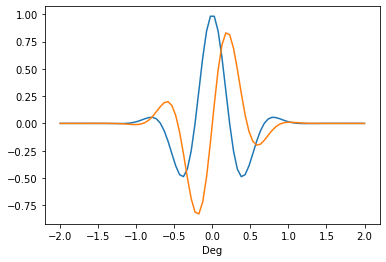

In [200]:
#plot the resulting even and odd spatial filters. 
plt.plot(x_filt,even_x)
plt.plot(x_filt,odd_x)
plt.xlabel('Deg')

These two filters are a quadrature pair. What does that mean? Well it means that you can sum them up to tile some space in question. In this case space. What would I get if I were to square and add these two filters in space? Well each has a cos componenet or a sin component, and both have a gaussian component. So we can do a little simple algebra. 


$ G = gaussian$
$$ (G*sin(x))^2 + (G*cos(x))^2$$
$$ G^2 * (sin(x)^2 + cos(x)^2) $$
$$ G^2 * 1$$

remember $sin(x)^2 + cos(x)^2 = 1$


[None, None, Text(0.5, 1.0, 'even_x^2 + odd_x^2')]

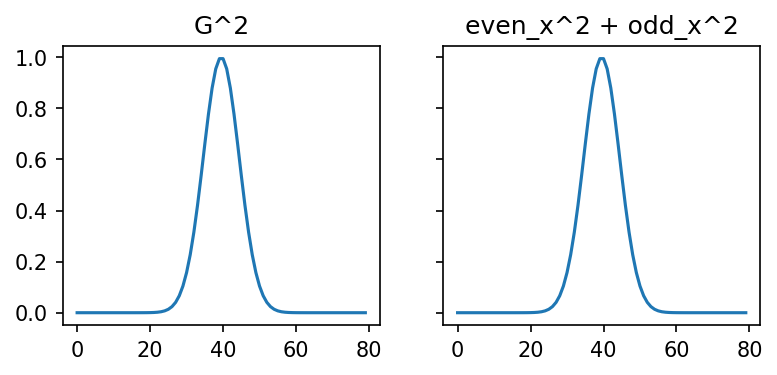

In [201]:
#does that hold true? Let's plot G^2 vs even_x^2 + odd_x^2

fig2, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,dpi = 150)

ax1.plot(gauss**2)

ax2.plot(even_x**2 + odd_x**2)
ax1.set(adjustable='box',aspect=70,title='G^2')
ax2.set(adjustable='box',aspect=70,title='even_x^2 + odd_x^2')




### define temporal filters

In [202]:
slow_t=(k*t_filt)**slow_n * np.exp(-k*t_filt)*(1/mth.factorial(slow_n)-beta*((k*t_filt)**2)/mth.factorial(slow_n+2));
fast_t=(k*t_filt)**fast_n * np.exp(-k*t_filt)*(1/mth.factorial(fast_n)-beta*((k*t_filt)**2)/mth.factorial(fast_n+2));

These two filters are the building block of the energy model. They indicate how a cell might response to a small pulse of contrast, you can play around with the parameters to gain an intuition as to what is going on. For example change the beta values.  Each filter can be thought of as the **temporal** analogue of quadrature pairing, though not exactly truly in quadrature, the slow down of one relative to another is enough to actually approximate quadrature pairing in the temporal domain. 

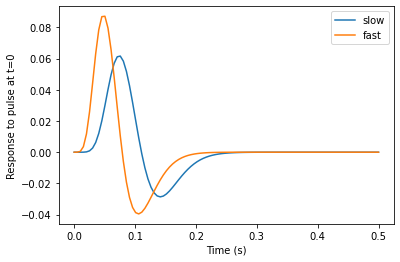

In [204]:
# plot temporal filters to illustrate what they look like. 
ax = plt.plot(t_filt,slow_t,label='slow')
ax = plt.plot(t_filt,fast_t,label='fast')
plt.xlabel('Time (s)')
plt.ylabel('Response to pulse at t=0')
plt.legend()

### Combine filters to create four spatiotemporally separable ones.

The motion energy model first begins by creating four spatial temporally separable 2D filters. Taking all potential combinations of even vs odd spatial filters, and fast vs slow temporal ones. 

In [139]:
# we first create spat
e_slow = np.outer(slow_t,even_x)
o_slow = np.outer(slow_t,odd_x)
e_fast = np.outer(fast_t,even_x)
o_fast = np.outer(fast_t,odd_x)

[Text(0.5, 0, 'Space (pix)')]

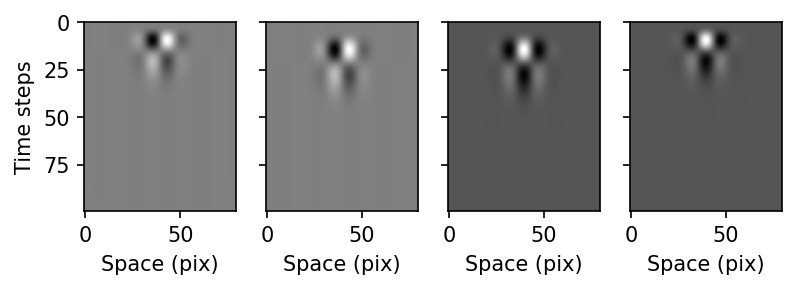

In [140]:
# Let's look at each of these filters and see what they look like. 
# Each plot below shows how a particular filter
# adds up luminance over time and across space

fig2, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True,dpi = 150)
ax1.imshow(o_fast,cmap=plt.get_cmap('gray'))
ax1.set(ylabel='Time steps')
ax1.set(xlabel='Space (pix)')
ax2.imshow(o_slow,cmap=plt.get_cmap('gray'))
ax3.imshow(e_slow,cmap=plt.get_cmap('gray'))
ax4.imshow(e_fast,cmap=plt.get_cmap('gray'))
ax2.set(xlabel='Space (pix)')
ax3.set(xlabel='Space (pix)')
ax4.set(xlabel='Space (pix)')



[(0.0, 80.0)]

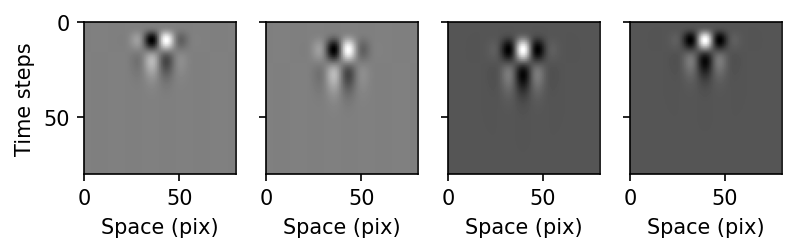

In [141]:
# to aid visualization, we can just look at the time points between 0-80 time points, and 0 and 80 pixels. 

fig2, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True,sharex=True,dpi = 150)
ax1.imshow(o_fast,cmap=plt.get_cmap('gray'))
ax1.set(ylabel='Time steps')
ax1.set(xlabel='Space (pix)')
ax2.imshow(o_slow,cmap=plt.get_cmap('gray'))
ax3.imshow(e_slow,cmap=plt.get_cmap('gray'))
ax4.imshow(e_fast,cmap=plt.get_cmap('gray'))
ax2.set(xlabel='Space (pix)')
ax3.set(xlabel='Space (pix)')
ax4.set(xlabel='Space (pix)')
ax1.set(ylim=(80,0))
ax1.set(xlim=(0,80))

### Create direction selective filters (simple cells)


This is where things get nifty, by taking the appropriate sums of these non-directional cells, you can ***create*** directional ones


In [142]:
left_1=o_fast+e_slow;      # First leftward preferring filter
left_2=-o_slow+e_fast;     # Second leftward preferring filter
right_1=-o_fast+e_slow;    # Third leftward preferring filter
right_2=o_slow+e_fast;     # Fourth leftward preferring filter

Graphically, you are doing the following
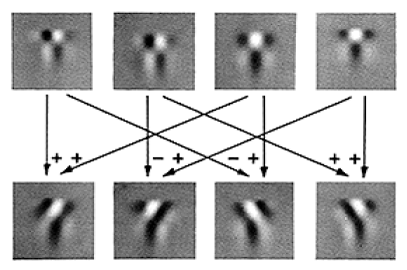

[Text(0.5, 0, 'Space (pix)')]

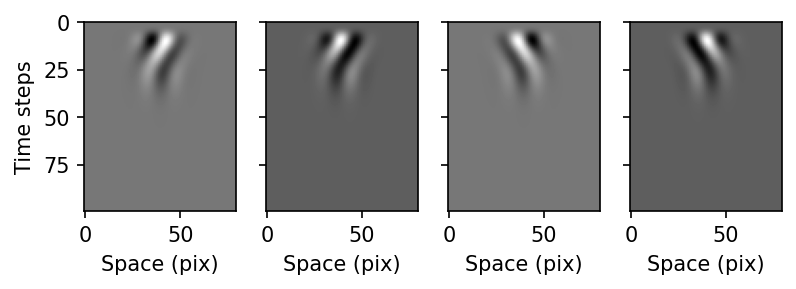

In [143]:
# Let's look at each of these filters and see what they look like. 
# Each plot below shows how a particular filter
# adds up luminance over time and across space. Note how they look tilted!!!!!

fig2, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True,sharex=True,dpi = 150)
ax1.imshow(left_1,cmap=plt.get_cmap('gray'))
ax1.set(ylabel='Time steps')
ax1.set(xlabel='Space (pix)')
ax2.imshow(left_2,cmap=plt.get_cmap('gray'))
ax3.imshow(right_1,cmap=plt.get_cmap('gray'))
ax4.imshow(right_2,cmap=plt.get_cmap('gray'))
ax2.set(xlabel='Space (pix)')
ax3.set(xlabel='Space (pix)')
ax4.set(xlabel='Space (pix)')


#### Now we need a stimulus

We've reached the point in this model where we need a stimulus. I'm going to use the example of a random dot kinematogram. In 1D you can think of it sort of like a set of lines that move to the right or left. 
    

In [149]:
#start with a large number of 0s/1s
start = np.double(np.random.rand(1,80*80)>.5)

# make a movie by sliding a window across this in time. Let's imagine it is moving 4 pixels per time step. 
#Consider a 1 second stimulus. If 100 samples is .5 seconds, 200 samples is 2 seconds. Let's also consider a 8
#degree stimulus. 80 pixels is 4 degrees, so 160 pixels should be 8 degrees.

stim = np.zeros((200,160)) #preallocate array which is 1 seconds x 8 degrees in size
pix_per_frame = 4; #stimulus moves 4 pixels per frame
for i in range(200):
    buf = "%d:%d" % (i*pix_per_frame, i*pix_per_frame + (160-1))
    a = i*pix_per_frame
    b = i*pix_per_frame + (160)
    stim[i,:] = start[0,a:b]
    

In [150]:
# A little movie magic, we can look at our stimulus over time
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)

fig = plt.figure()
img = np.tile(stim[0,:],(160,1))

im = plt.imshow(img,cmap=plt.get_cmap('gray'))

plt.close() # this is required to not display the generated image

def init():
    img = np.tile(stim[0,:],(160,1))

    im.set_data(img)

def animate(i):
    img = np.tile(stim[i,:],(160,1))

    im.set_data(img)
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=img.shape[0],
                               interval=60)
HTML(anim.to_html5_video())

In [237]:
# we can compare that to a stimulus very similar to what was presented in Adelson Bergen 1985
A = np.load('./dots.npy')

In [152]:
# More Movie Magic
fig = plt.figure()
img = np.tile(A[0,:],(161,1))

im = plt.imshow(img,cmap=plt.get_cmap('gray'))

plt.close() # this is required to not display the generated image

def init():
    img = np.tile(A[0,:],(161,1))

    im.set_data(img)

def animate(i):
    img = np.tile(A[i,:],(161,1))

    im.set_data(img)
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=img.shape[0],
                               interval=60)
HTML(anim.to_html5_video())

### Time to generate the responses of the direction selective filters (aka. simple cells)

In [238]:
#convolve 2D filters with images
# Rightward responses

resp_right_1=conv2(A,right_1,'valid');
resp_right_2=conv2(A,right_2,'valid');

# Leftward responses
resp_left_1=conv2(A,left_1,'valid');
resp_left_2=conv2(A,left_2,'valid');

### Next we create complex cell responses. We square and sum the output of these "simple cells"

In [239]:
resp_left_1 = resp_left_1**2;
resp_left_2 = resp_left_2**2;
resp_right_1 = resp_right_1**2;
resp_right_2 = resp_right_2**2;

# Calc total left and right energy according to these filters. THESE ARE THE COMPLEX CELLS
energy_right= resp_right_1 + resp_right_2;
energy_left= resp_left_1 + resp_left_2;

# These are the so called "energy" cells, their response is quantifying energy moving to the right and to the left over time.

Text(0.5, 1.0, 'Motion contrast')

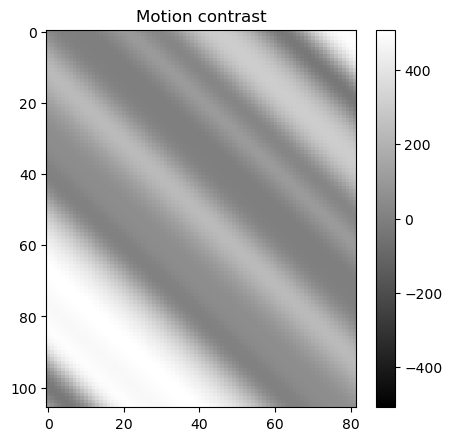

In [240]:
# let's plot the output of these responses. We will use a measure called "motion contrast"

energy_opponent = energy_right - energy_left # L-R difference matrix
[xv,yv] = np.shape(energy_left) # Get the size of the response matrix
energy_flicker = total_energy/(xv * yv) # A value for average total energy

# Re-scale (normalize) each pixel in the L-R matrix using average energy.
motion_contrast = energy_opponent/energy_flicker;


# Plot, scaling by max L or R value
mc_max = np.max(np.max(motion_contrast))
mc_min = np.min(np.min(motion_contrast))
if (abs(mc_max) > abs(mc_min)):
    peak = abs(mc_max)
else:
    peak = abs(mc_min)

plt.figure(figsize=(5, 5), dpi=100)

ax = plt.imshow(motion_contrast,cmap=plt.get_cmap('gray'),aspect='auto')
ax.set(clim = [-peak,peak])
plt.colorbar()
plt.title('Motion contrast')



That looks interesting, but what does it mean? Let's sum across time and take a look at how much this cell is voting for rightward vs leftward energy!

In [241]:
# Calc total energy

total_energy = np.sum(np.sum(energy_right))+np.sum(np.sum(energy_left));
 

# Normalise
RR1 = np.sum(np.sum(resp_right_1))/total_energy;
RR2 = np.sum(np.sum(resp_right_2))/total_energy;
LR1 = np.sum(np.sum(resp_left_1))/total_energy;
LR2 = np.sum(np.sum(resp_left_2))/total_energy;

right_Total = RR1+RR2
left_Total = LR1+LR2
motion_energy = right_Total - left_Total;



Text(0.5, 1.0, 'Motion contrast = 0.834889')

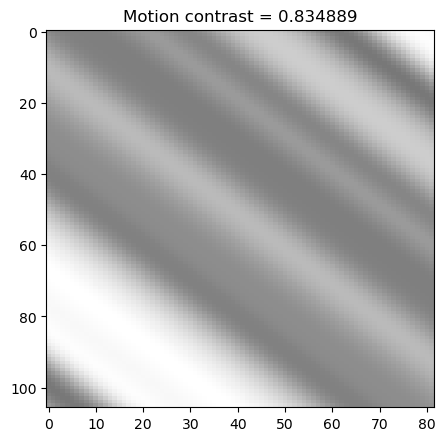

In [242]:
# now we can put a number between -1 and 1 on how much net rightward motion energy there is. +1 = right, -1 = left
plt.figure(figsize=(5, 5), dpi=100)

ax = plt.imshow(motion_contrast,cmap=plt.get_cmap('gray'),aspect='auto')
ax.set(clim = [-peak,peak])
t = 'Motion contrast = %2f' %motion_energy
plt.title(t)